Before you turn this lab in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
DRIVER = "Mike"
NAVIGATOR = "Jonathan"

# Generative Adversarial Networks Training Lab

Welcome to the generative adversarial networks lab! By the end of this lab, you will have

- Hooked together a generator $\mathcal{G}$ and discriminator $\mathcal{D}$ to build a generative adversarial model $\mathcal{A}$
- Optimized $\mathcal{G}$ to produce realistic data points via adversarial training

Let's get started!

# Unit Test Variables

The following code defines variables that will be used in subsequent unit tests. Do not attempt to redefine any of these variables throughout the notebook!

In [2]:
import numpy as np
np.random.seed(42)

BS_ = 128
Z_ = np.random.uniform(low=-1, high=1, size=BS_)

def passed(): print('✅')

# Synthetic Data

The following code defines a python generator which yields samples from a normal distribution and plots 1,000 samples.

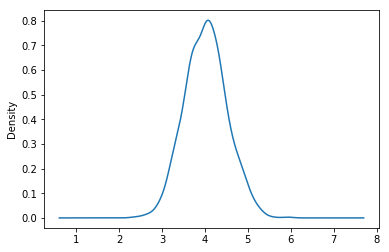

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline

def data_distribution(mu, sigma):
    while True:
        z = sigma*np.random.randn() + mu
        yield z
        
data_point = data_distribution(mu=4, sigma=0.5)
pd.Series(next(data_point) for _ in range(1_000)).plot(kind='kde');

## Task

- Load $\mathcal{G}$ and $\mathcal{D}$ into memory

## Requirement

- Save them into python variables named `G` and `D` respectively

In [4]:
from keras.models import load_model

G = load_model('G.h5') #../../6_1_am_generative_adversarial_networks_I/lab/weights/ my machine
D = load_model('D.h5') #../../6_1_am_generative_adversarial_networks_I/lab/weights/ my machine


Using TensorFlow backend.
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 31.0
Trainable params: 31
Non-trainable params: 0.0
_________________________________________________________________


In [6]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 31.0
Trainable params: 31
Non-trainable params: 0.0
_________________________________________________________________


# Load Models Tests

In [7]:
import keras

assert type(G) == keras.models.Sequential
assert G.input_shape == (None, 1)
assert G.output_shape == (None, 1)
assert G.predict(Z_).shape == (128, 1)
assert type(D) == keras.models.Sequential
assert D.output_shape == (None, 1)
assert D.input_shape == (None, 1)

passed()

✅


## Task

- Hook together $\mathcal{G}$ and $\mathcal{D}$ to create $\mathcal{A}$

## Hints

- Use the keras functional api to connect together $\mathcal{G}$ and $\mathcal{D}$
- Recall the interface for $\mathcal{A}$

<img src="images/Fancy GAN.svg" alt="GAN" style="width: 300px;"/>

## Requirements

- Save $\mathcal{A}$ into a python variable named `GAN`

## Hint

- Use `keras.layers.Input` as the first layer in your model to specify the input size

In [8]:
from keras.layers import Input
from keras.models import Model
from IPython.display import SVG

z = Input(shape=[1])
X_fake = G(z)
p = D(X_fake)

GAN = Model(inputs=z, outputs=p, name='GAN')
GAN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

GAN.summary()
#SVG(model_to_dot(GAN).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 31        
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 31        
Total params: 62.0
Trainable params: 62.0
Non-trainable params: 0.0
_________________________________________________________________


# Generative Adversarial Network Tests

In [9]:
import numpy as np

def test_gan(G, D, GAN):
    assert type(GAN) == keras.engine.training.Model
    assert GAN.input_shape == G.input_shape
    assert GAN.output_shape == D.output_shape
    assert GAN.loss == D.loss
    assert GAN.metrics == D.metrics
    assert type(GAN.optimizer) == type(D.optimizer)
    bs_ = 16
    z_ = np.random.uniform(low=-1, high=1, size=[bs_, 1])
    X_fake_ = G.predict(z_)
    assert np.all(GAN.predict(z_) == D.predict(X_fake_))
    
    for l1, l2 in zip(GAN.layers[1].layers, G.layers):
        W1 = [ww for w in l1.get_weights() for ww in w]
        W2 = [ww for w in l2.get_weights() for ww in w]
        for w1, w2 in zip(W1, W2):
            assert np.all(w1 == w2)
        
    for l1, l2 in zip(GAN.layers[2].layers, D.layers):
        W1 = [ww for w in l1.get_weights() for ww in w]
        W2 = [ww for w in l2.get_weights() for ww in w]
        for w1, w2 in zip(W1, W2):
            assert np.all(w1 == w2)
    
test_gan(G, D, GAN)
passed()

✅


# Building Up to the Full Training Loop Solution

## Task

- Train $\mathcal{D}$ on a batch of two data points ${\tt X = [\widetilde{x} \ ; x]}$ and ${\tt y = [0, 1]}$

## Requirements

- Save your sample from the noise distribution into a python variable named `z`
- Save your batch of two training examples into python variables named `X` and `y`
- Save the accuracy and loss into python variables named `accuracy` and `loss`

In [10]:
data_point

<generator object data_distribution at 0x1172c7888>

In [11]:
import scipy.stats as stats

In [12]:
X_r = np.array([next(data_point) for _ in range(100)]).reshape(-1,1)
X_f = G.predict(stats.uniform(-1,1).rvs(100))

In [13]:
X_f = G.predict(stats.uniform(-1,1).rvs(100))

In [14]:
X = np.array([X_f[0],X_r[0]])

In [15]:
X

array([[-0.18261769],
       [ 3.77078153]])

In [16]:
y = np.array([0,1])

In [17]:
y

array([0, 1])

In [18]:
loss, accuracy = D.train_on_batch(X,y)

In [19]:
loss

0.78846216

# Discriminator Training Tests

In [20]:
z = X_f[0].reshape(-1,1)

In [21]:
assert z.shape == (1, 1)
assert len(X) == 2
assert np.all(y == [0, 1])
l_, a_ = D.train_on_batch(X, y)
assert l_ <= loss
assert a_ >= accuracy

W_d_ = [w for layer in D.layers for w in layer.get_weights()]
W_g_ = [w for layer in G.layers for w in layer.get_weights()]

passed()

✅


## Task

- Train $\mathcal{G}$ on a single adversarial training example `(z, 1)`

## Hints

- Make sure you freeze the weights of the discriminator so you don't step $\theta_\mathcal{D}$ in the wrong direction!
- You can use the `lib.keras_utils.freeze()` context manager to freeze $\mathcal{D}$'s weights. Here is an example illustrating usage and semantics.

#### Without `lib.keras_utils.freeze()`

```python
p = D.predict(X)
GAN.train_on_batch(z, y)
assert D.predict(X) != p # different weights, different prediction
```

#### With `lib.keras_utils.freeze()`

```python
from lib.keras_utils import freeze
with freeze(GAN, D):
    X_fake = G.predict(z)
    p = D.predict(X_fake)
    GAN.train_on_batch(z, y)
    assert D.predict(X_fake) == p # same weights, same prediction for D
    assert G.predict(z) != X_fake # different weights, different prediction for G
```

## Reminder

- Make sure you do **not** update $\theta_\mathcal{D}$!

In [22]:
from lib.keras_utils import freeze

In [23]:
z

array([[-0.18261769]], dtype=float32)

In [24]:
y_real = np.array([y[0]]).reshape(-1,1)

In [25]:
y_real.shape

(1, 1)

In [26]:
p

<tf.Tensor 'sequential_2/dense_4/Sigmoid:0' shape=(?, 1) dtype=float32>

In [27]:
with freeze(GAN, D):
        X_test = G.predict(z)
        p = D.predict(X_test)
        loss, acc = GAN.train_on_batch(z, y_real)
        assert D.predict(X_test) == p 
        assert G.predict(z) != X_fake

In [28]:
loss

0.7027362

In [29]:
acc

0.0

# Generator Training Tests

In [30]:
for w_d_old_, w_d_new_ in zip(W_d_, [w for layer in D.layers for w in layer.get_weights()]):
    assert np.all(w_d_old_ == w_d_new_)
    
test_gan(G, D, GAN)
passed()

✅


## Task

- Generalize your code to train $\mathcal{G}$ to produce realistic synthetic images with generative adversarial training

## Suggestions

- Track the loss for $\mathcal{G}$ and $\mathcal{D}$ over time as well as accuracy for $\mathcal{A}$ to see who is winning
- Have $\mathcal{G}$ generate some images every few epochs to visualize what it is learning

## Goal

- Optimize $\mathcal{G}$ so that it maps the 128 data points `Z_` (defined in the first code cell in this lab) from the noise distribution to data points close to the data points from the data distribution

## Constraints

- Do not run for more than 250 epochs

In [31]:
from IPython import display
import matplotlib.pyplot as plt
from collections import defaultdict
from lib.keras_utils import freeze

batch_size = 64
nb_epoch = 100
plot_every = 1


#

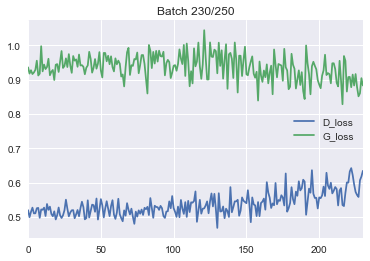

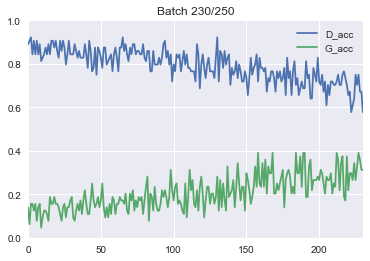

32/64 [==============>...............] - ETA: 0s

KeyboardInterrupt: 

In [43]:
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from lib.keras_utils import freeze
from keras.utils.np_utils import to_categorical

batch_size = 64
nb_epoch = 250
plot_every = 5


L, A = defaultdict(list), defaultdict(list)
for i in range(nb_epoch):
    z = np.random.uniform(low=-1, high=1, size=[batch_size])
    y_fake, y_real = np.zeros(batch_size), np.ones(batch_size)
    X_real, X_fake = np.array([next(data_point) for _ in range(batch_size)]).reshape(-1,1), G.predict(z)
    X, y = np.concatenate([X_fake, X_real]), np.concatenate([y_fake, y_real])
    
    # train discriminator
    loss, acc = D.train_on_batch(X, y)
    loss, acc = D.evaluate(X_fake, y_fake)
    
    L['D_loss'].append(float(loss)); A['D_acc'].append(float(acc))
    
    # new Z's to train the Generator on
    z = np.random.uniform(low=-1, high=1, size=[batch_size])
    
    with freeze(GAN, D):
        loss, acc = GAN.train_on_batch(z, y_real)
        
        L['G_loss'].append(float(loss)); A['G_acc'].append(float(acc))
    

        
    if i % 10 == 0:
        
        display.clear_output(wait=True)
        pd.DataFrame(L).plot(title='Batch {}/{}'.format(i, nb_epoch))
        axes = pd.DataFrame(A).plot(title='Batch {}/{}'.format(i, nb_epoch))
        axes.set_ylim([0, 1])
        plt.show()

#     z = np.random.uniform(low=-1, high=1, size=[8, 100])
#     X_fake = G.predict(z)
#     for x in X_fake:
#         img = array_to_img(x).resize(size=[64, 64])
#         display.display(img)

## Task

- Plot samples from your trained generator and samples from the real data distribution on the same plot

## Requirements

- Use a *kernel density estimation* plot for both types of samples

In [44]:
import seaborn as sns

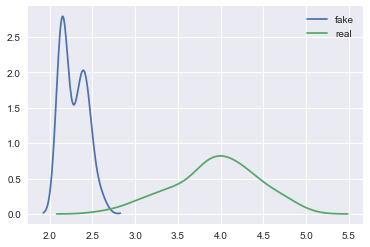

In [45]:
sns.kdeplot(G.predict(stats.uniform(-1, 1).rvs(batch_size)).ravel(), label='fake')
sns.kdeplot((np.array([next(data_point) for _ in range(batch_size)])), label='real')

## Task

- Evaluate $\mathcal{D}$'s accuracy on the fake images $\mathcal{G}$ produces from `Z_`

## Requirements

- Save them into two python variables `loss` and `acc`

In [46]:
X_real, X_fake = np.array([next(data_point) for _ in range(batch_size)]).reshape(-1,1), G.predict(z)

In [47]:
loss,acc =  D.evaluate(X_fake,y_fake)

32/64 [==============>...............] - ETA: 0s

# Evaluate $\mathcal{D}$ Tests

In [48]:
assert type(loss) == np.float64
assert type(acc) == np.float64
assert 0 <= acc <= 1

passed()

✅


# Evaluate $\mathcal{G}$ Tests

In [49]:
X_fake_ = G.predict(Z_)
assert X_fake_.mean() > 0.5
passed()

✅


In [50]:
X_fake_ = G.predict(Z_)
assert X_fake_.mean() > 1.0
passed()

✅


In [51]:
X_fake_ = G.predict(Z_)
assert X_fake_.mean() > 1.5
passed()

✅
